In [1]:
#Set up the environment
library(reshape2)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
#Make a vector of all of the ancestry-associated genes
setwd("../data")
ancestry.associated.gene.vector = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = TRUE) %>%
filter(afr_fdr < 0.05 | amr_fdr < 0.05 | eas_fdr < 0.05 | eur_fdr < 0.05 | sas_fdr < 0.05) %>%
pull(gene) %>%
unique()

In [4]:
#Find the TSS for all of the ancestry-associated genes.
setwd("../data")
refgene = read.table("hg38.refGene.gtf", header = F, sep = "\t") %>%
select(V1, V3, V4, V5, V7, V9) %>%
rename("chr" = V1, "type" = V3, "start" = V4, "end" = V5, "strand" = V7, "gene" = V9) %>%
filter(type %in% "transcript") %>%
mutate("position" = ifelse(strand %in% "+", start, end)) %>%
mutate(gene = gsub(";..*", "", gene)) %>%
mutate(gene = gsub("gene_id ", "", gene)) %>%
select(chr, position, strand, gene) %>%
filter(gene %in% ancestry.associated.gene.vector) %>%
distinct(gene, .keep_all = TRUE)

In [5]:
#Load in the top SNP data
setwd("../data")
top.snp.df = read.table("ancestry_top_snp_df.txt", sep = "\t", header = TRUE)

In [6]:
#Create a merged dataset that has both the tss data and the significance data
merged.tss.and.sig.df = top.snp.df %>% 
inner_join(refgene, by = "gene") %>%
rename("tss_chr" = chr, "tss_pos" = position, "tss_strand"  = strand) %>%
separate(snp, sep = ":", into = c("top_snp_chr", "top_snp_pos", "top_snp_ref", "top_snp_alt")) %>%
select(-top_snp_ref, -top_snp_alt, -pval) %>%
mutate(top_snp_pos = as.numeric(top_snp_pos)) %>%
mutate("distance_to_tss" = ifelse(top_snp_chr == tss_chr, abs(top_snp_pos - tss_pos), 1000001)) %>%
mutate("prox_or_dist" = ifelse(distance_to_tss < 1000000, "proximal", "distal"))

In [7]:
#Calculate the number of proximal and distal genes
total.proximal = merged.tss.and.sig.df %>% filter(prox_or_dist %in% "proximal") %>% pull(gene) %>% unique() %>% length()
total.distal = merged.tss.and.sig.df %>% filter(prox_or_dist %in% "distal") %>% pull(gene) %>% unique() %>% length()

#Print the information
print(paste("the total number of proximal genes is:", total.proximal))
print(paste("the total number of distal genes is:", total.distal))

[1] "the total number of proximal genes is: 29"
[1] "the total number of distal genes is: 20"


In [8]:
#Write the table for future use
setwd('../output')
write.table(merged.tss.and.sig.df, "figure_2c_distance_to_tss_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

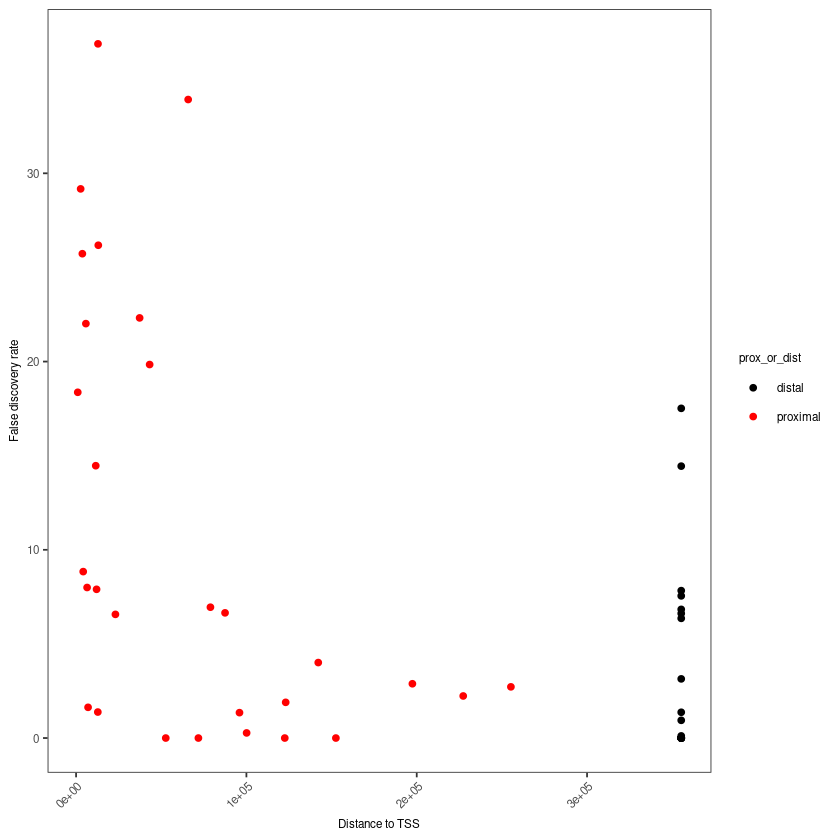

In [9]:
###Plot the FDR vs distance to tss

#Calculate the maximum distance for the proximal variants
max.dist.to.tss = merged.tss.and.sig.df %>%
filter(prox_or_dist %in% "proximal") %>%
pull(distance_to_tss) %>%
max()


#Make a plot of fdr vs distance to tss
merged.tss.and.sig.df %>%
mutate(distance_to_tss = ifelse(distance_to_tss > max.dist.to.tss, max.dist.to.tss + 100000, distance_to_tss)) %>%

ggplot(aes(x = distance_to_tss, y = -log10(fdr), color = prox_or_dist, fill = prox_or_dist)) +
geom_point() +
theme_bw() +

scale_color_manual(values = c("black", "red")) +
scale_fill_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
) +

ylab("False discovery rate") +
xlab("Distance to TSS")

#Export it to the google bucket
setwd('../output')
ggsave("figure_2c.pdf", width = 3, height = 2.95)